## Using a quadrilateral mesh in Fenics
This is painful; avoid if possible

In [1]:
import numpy as np
import dolfin as dl
import matplotlib.pyplot as plt

p0 = dl.Point(0.0, 0.0)
p1 = dl.Point(1.0, 1.0)
nx = 20
ny = 21

quad_mesh = dl.RectangleMesh.create([p0,p1], [nx,ny], dl.CellType.Type.quadrilateral) # <--- make quad mesh

V_quad = dl.FunctionSpace(quad_mesh, 'CG', 1)
u_trial = dl.TrialFunction(V_quad)
v_test = dl.TestFunction(V_quad)

A = dl.assemble(dl.inner(dl.grad(u_trial), dl.grad(v_test)) * dl.dx + u_trial * v_test * dl.dx)
b = dl.assemble(dl.Expression('sin(x[0]*x[1])', degree=3) * v_test * dl.dx)

u_quad = dl.Function(V_quad)
dl.solve(A, u_quad.vector(), b)

# dl.plot(u_quad) # <--- This will fail. Plotting of quad meshes not supported currently

1

### Idea 1: interpolate to triangle mesh for plotting

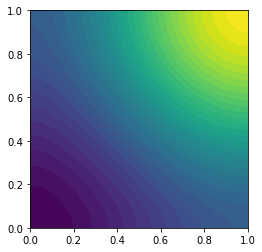

In [2]:
tri_mesh = dl.RectangleMesh(p0,p1, nx,ny)
V_tri = dl.FunctionSpace(tri_mesh, 'CG', 1)

# u_tri = dl.interpolate(u_quad, V_tri) # <--- This will fail. Interpolation from quad mesh not supported either

# Must transfer d.o.f. values manually
# d.o.f. nodes must exactly match for this to work
quad_coords = V_quad.tabulate_dof_coordinates()
tri_coords = V_tri.tabulate_dof_coordinates()

quad_sort_inds = np.lexsort(quad_coords.T)
tri_sort_inds = np.lexsort(tri_coords.T)

def tri2quad(ut):
    uq = ut.copy()
    uq[quad_sort_inds] = ut[tri_sort_inds]
    return uq
    
def quad2tri(uq):
    ut = uq.copy()
    ut[tri_sort_inds] = uq[quad_sort_inds]
    return ut

u_tri = dl.Function(V_tri)
u_tri.vector()[:] = quad2tri(u_quad.vector())

dl.plot(u_tri)

### Solve on tri mesh also to check correctness

In [3]:
V_tri = dl.FunctionSpace(tri_mesh, 'CG', 1)
u_trial = dl.TrialFunction(V_tri)
v_test = dl.TestFunction(V_tri)

A = dl.assemble(dl.inner(dl.grad(u_trial), dl.grad(v_test)) * dl.dx + u_trial * v_test * dl.dx)
b = dl.assemble(dl.Expression('sin(x[0]*x[1])', degree=3) * v_test * dl.dx)

u_tri2 = dl.Function(V_tri)
dl.solve(A, u_tri2.vector(), b)

err_tri_vs_quad = np.sqrt(dl.assemble((u_tri - u_tri2)**2 * dl.dx)) / np.sqrt(dl.assemble((u_tri2)**2 * dl.dx))
print('err_tri_vs_quad=', err_tri_vs_quad)

err_tri_vs_quad= 7.958561389333878e-05
